https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [1]:
import os
import tempfile

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

In [2]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
file = keras.utils

raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
raw_df[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V26', 'V27', 'V28', 'Amount', 'Class']].describe()

,Time,V1,V2,V3,V4,V5,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [6]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos

print(f'Examples:\n    Total: {total}\n    Positive: {pos} ({100 * pos / total:.2f}% of total)')

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)


In [7]:
cleaned_df = raw_df.copy()

# You don't want tha 'Time' column
cleaned_df.pop('Time')

# The 'Amount' column covers a huge range. Convert to log-space
eps = 0.001 # 0 -> 0.1
cleaned_df['Log Amount'] = np.log(cleaned_df.pop('Amount') + eps)

In [8]:
# Use a utility from sklearn to split and shuffle your dataset
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features
train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0

val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [9]:
scaler = StandardScaler()

train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)

print(f'Training labels shape: {train_labels.shape}')
print(f'Validation labels shape: {val_labels.shape}')
print(f'Test labels shape: {test_labels.shape}')

print(f'Training features shape: {train_features.shape}')
print(f'Validation features shape: {val_features.shape}')
print(f'Test features shape: {test_features.shape}')

Training labels shape: (182276,)
Validation labels shape: (45569,)
Test labels shape: (56962,)
Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


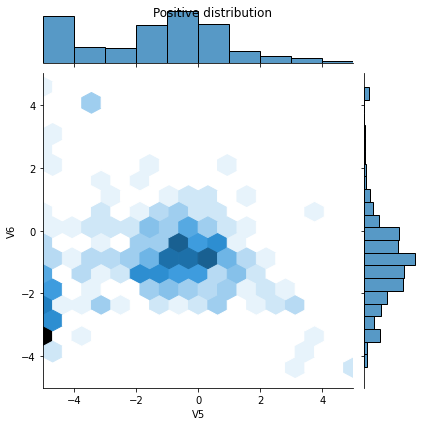

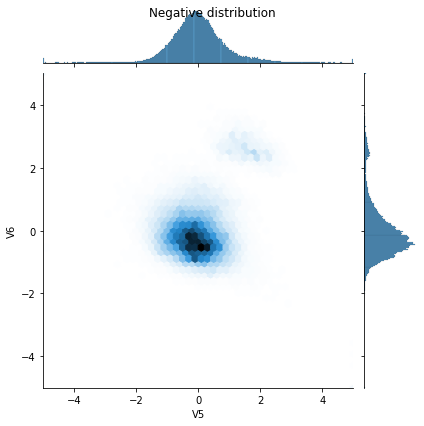

In [10]:
pos_df = pd.DataFrame(train_features[bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(
    x=pos_df['V5'],
    y=pos_df['V6'],
    kind='hex',
    xlim=(-5, 5),
    ylim=(-5, 5)
)

plt.suptitle('Positive distribution')

sns.jointplot(
    x=neg_df['V5'],
    y=neg_df['V6'],
    kind='hex',
    xlim=(-5, 5),
    ylim=(-5, 5)
)

_ = plt.suptitle('Negative distribution')

In [11]:
METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR') # Precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = keras.initializers.Constant(output_bias)

    model = keras.Sequential([
        keras.layers.Dense(16, activation='relu', input_shape=(train_features.shape[-1],)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics
    )

    return model

In [12]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_prc',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True
)

In [13]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                480       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.predict(train_features[:10])

1/1 [==============================] - 2s 2s/step


array([[0.87586755],
       [0.54639214],
       [0.64830536],
       [0.7506618 ],
       [0.61109215],
       [0.62604564],
       [0.8507706 ],
       [0.78400683],
       [0.9378255 ],
       [0.87048507]], dtype=float32)

In [15]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print(f'Loss: {results[0]:0.4f}')

Loss: 1.8472


In [16]:
initial_bias = np.log([pos / neg])
initial_bias

array([-6.35935934])

In [17]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

1/1 [==============================] - 0s 40ms/step


array([[0.00059394],
       [0.0006161 ],
       [0.00080168],
       [0.00207876],
       [0.00176925],
       [0.00041739],
       [0.00060675],
       [0.00149705],
       [0.00025412],
       [0.0011355 ]], dtype=float32)

In [18]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print(f'Loss: {results[0]:0.4f}')

Loss: 0.0130


In [19]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [20]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])

zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels),
    verbose=0
)

In [21]:
model = make_model()
model.load_weights(initial_weights)

careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels),
    verbose=0
)

In [22]:
def plot_loss(history, label, n):
    # Use a log scale on y-axis to show the wide range of values
    plt.semilogy(
        history.epoch,
        history.history['loss'],
        color=colors[n],
        label='Train ' + label
    )

    plt.semilogy(
        history.epoch,
        history.history['val_loss'],
        color=colors[n],
        label='Val ' + label,
        linestyle='--'
    )

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

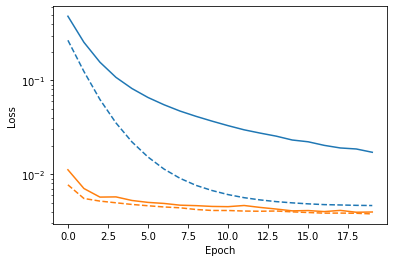

In [23]:
plot_loss(zero_bias_history, 'Zero Bias', 0)
plot_loss(careful_bias_history, 'Careful Bias', 1)

In [24]:
model = make_model()
model.load_weights(initial_weights)

baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels)
)

Epoch 1/100
90/90 [==============================] - 2s 14ms/step - loss: 0.0109 - tp: 61.0000 - fp: 16.0000 - tn: 227421.0000 - fn: 347.0000 - accuracy: 0.9984 - precision: 0.7922 - recall: 0.1495 - auc: 0.7783 - prc: 0.2424 - val_loss: 0.0077 - val_tp: 2.0000 - val_fp: 0.0000e+00 - val_tn: 45490.0000 - val_fn: 77.0000 - val_accuracy: 0.9983 - val_precision: 1.0000 - val_recall: 0.0253 - val_auc: 0.8855 - val_prc: 0.6058
Epoch 2/100
90/90 [==============================] - 1s 8ms/step - loss: 0.0071 - tp: 98.0000 - fp: 18.0000 - tn: 181929.0000 - fn: 231.0000 - accuracy: 0.9986 - precision: 0.8448 - recall: 0.2979 - auc: 0.8918 - prc: 0.5201 - val_loss: 0.0055 - val_tp: 36.0000 - val_fp: 9.0000 - val_tn: 45481.0000 - val_fn: 43.0000 - val_accuracy: 0.9989 - val_precision: 0.8000 - val_recall: 0.4557 - val_auc: 0.8920 - val_prc: 0.6344
Epoch 3/100
90/90 [==============================] - 1s 7ms/step - loss: 0.0059 - tp: 156.0000 - fp: 25.0000 - tn: 181922.0000 - fn: 173.0000 - accuracy

In [29]:
def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']

    for n, metric in enumerate(metrics):
        name = metric.replace('_', ' ').capitalize()

        plt.subplot(2, 2, n + 1)

        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_' + metric], color=colors[0], label='Val', linestyle='--')

        plt.xlabel('Epoch')
        plt.ylabel(name)

        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])

        elif metric == 'auc':
            plt.ylim([0.8, 1])

        else:
            plt.ylim([0, 1])

        plt.legend;

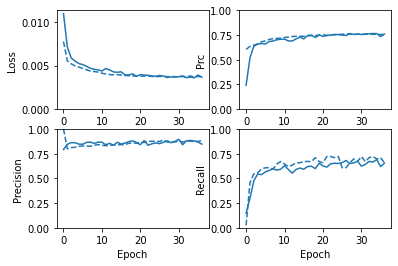

In [30]:
plot_metrics(baseline_history)

In [31]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

28/28 [==============================] - 0s 1ms/step


In [32]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)

    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f'Confusion matrix @{p:.2f}')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print(f'Legitimate transactions detected (True negative): {cm[0][0]}')
    print(f'Legitimate transactions incorrecty detected (False positives): {cm[0][1]}')
    print(f'Fraudulent transactions missed (False negatives): {cm[1][0]}')
    print(f'Fraudulent transactions detected (True positives): {cm[1][1]}')
    print(f'Total fraudulent transactions: {np.sum(cm[1])}')

loss: 0.0017013935139402747
tp: 71.0
fp: 8.0
tn: 56870.0
fn: 13.0
accuracy: 0.9996313452720642
precision: 0.8987341523170471
recall: 0.8452380895614624
auc: 0.9700826406478882
prc: 0.8881384134292603
Legitimate transactions detected (True negative): 56870
Legitimate transactions incorrecty detected (False positives): 8
Fraudulent transactions missed (False negatives): 13
Fraudulent transactions detected (True positives): 71
Total fraudulent transactions: 84


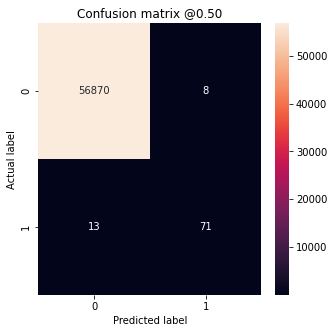

In [33]:
baseline_results = model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(model.metrics_names, baseline_results):
    print(f'{name}: {value}')

plot_cm(test_labels, test_predictions_baseline)

In [34]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100 * fp, 100 * tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5, 20])
    plt.ylim([80, 100.5])
    plt.grid(True)

    ax = plt.gca()
    ax.set_aspect('equal')

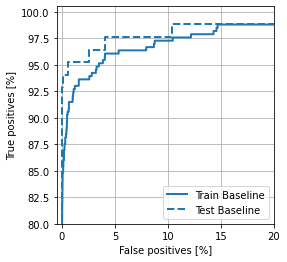

In [36]:
plot_roc('Train Baseline', train_labels, train_predictions_baseline, color=colors[0])
plot_roc('Test Baseline', test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [37]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)

    ax = plt.gca()
    ax.set_aspect('equal')

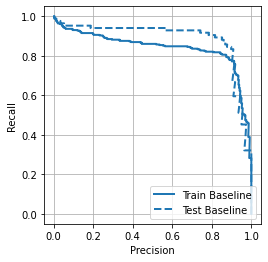

In [38]:
plot_prc('Train Baseline', train_labels, train_predictions_baseline, color=colors[0])
plot_prc('Test Baseline', test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [39]:
# Scaling by total / 2 helps keep the loss to a similar magnitude. The sum of the weights of all examples stays the same
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / neg) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f'Weight for class 0: {weight_for_0:.2f}')
print(f'Weight for class 1: {weight_for_1:.2f}')

Weight for class 0: 0.50
Weight for class 1: 0.50


In [42]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),

    # The class weights go here
    class_weight=class_weight
)

Epoch 1/100
90/90 [==============================] - 3s 17ms/step - loss: 0.0054 - tp: 85.0000 - fp: 15.0000 - tn: 238810.0000 - fn: 328.0000 - accuracy: 0.9986 - precision: 0.8500 - recall: 0.2058 - auc: 0.7908 - prc: 0.3028 - val_loss: 0.0076 - val_tp: 2.0000 - val_fp: 0.0000e+00 - val_tn: 45490.0000 - val_fn: 77.0000 - val_accuracy: 0.9983 - val_precision: 1.0000 - val_recall: 0.0253 - val_auc: 0.8855 - val_prc: 0.6073
Epoch 2/100
90/90 [==============================] - 1s 8ms/step - loss: 0.0033 - tp: 94.0000 - fp: 21.0000 - tn: 181926.0000 - fn: 235.0000 - accuracy: 0.9986 - precision: 0.8174 - recall: 0.2857 - auc: 0.9106 - prc: 0.5623 - val_loss: 0.0055 - val_tp: 39.0000 - val_fp: 9.0000 - val_tn: 45481.0000 - val_fn: 40.0000 - val_accuracy: 0.9989 - val_precision: 0.8125 - val_recall: 0.4937 - val_auc: 0.8920 - val_prc: 0.6391
Epoch 3/100
90/90 [==============================] - 1s 8ms/step - loss: 0.0030 - tp: 163.0000 - fp: 29.0000 - tn: 181918.0000 - fn: 166.0000 - accuracy

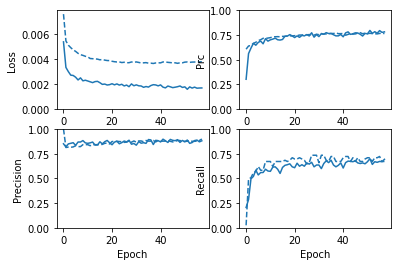

In [43]:
plot_metrics(weighted_history)

In [44]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

28/28 [==============================] - 0s 909us/step


loss: 0.0016266629099845886
tp: 72.0
fp: 10.0
tn: 56868.0
fn: 12.0
accuracy: 0.9996137619018555
precision: 0.8780487775802612
recall: 0.8571428656578064
auc: 0.9700457453727722
prc: 0.8917865753173828
Legitimate transactions detected (True negative): 56868
Legitimate transactions incorrecty detected (False positives): 10
Fraudulent transactions missed (False negatives): 12
Fraudulent transactions detected (True positives): 72
Total fraudulent transactions: 84


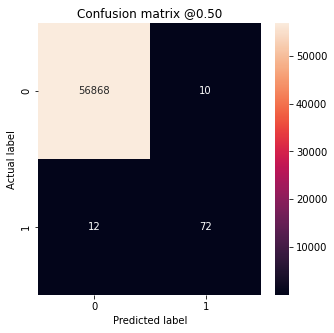

In [45]:
weighted_results = weighted_model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(f'{name}: {value}')

plot_cm(test_labels, test_predictions_weighted)

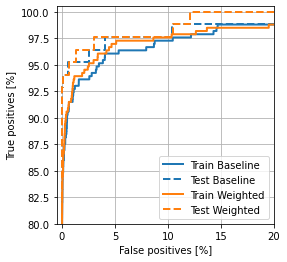

In [47]:
plot_roc('Train Baseline', train_labels, train_predictions_baseline, color=colors[0])
plot_roc('Test Baseline', test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc('Train Weighted', train_labels, train_predictions_weighted, color=colors[1])
plot_roc('Test Weighted', test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plt.legend(loc='lower right');

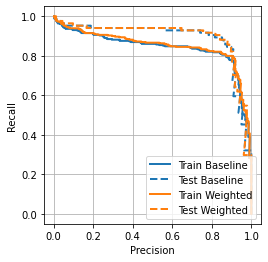

In [48]:
plot_prc('Train Baseline', train_labels, train_predictions_baseline, color=colors[0])
plot_prc('Test Baseline', test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc('Train Weighted', train_labels, train_predictions_weighted, color=colors[1])
plot_prc('Test Weighted', test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plt.legend(loc='lower right');

In [49]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

In [50]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(181947, 29)

In [51]:
resampled_fetures = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)

resampled_fetures = resampled_fetures[order]
resampled_labels = resampled_labels[order]

resampled_fetures.shape

(363894, 29)

In [52]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
    ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
    ds = ds.shuffle(BUFFER_SIZE).repeat()
    return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [53]:
for features, label in pos_ds.take(1):
    print(f'Features:\n{features.numpy()}')
    print(f'Label: {label.numpy()}')

Features:
[-0.45622103  0.85310429  0.80657347  1.17443718  0.73643807 -0.55380342
  0.69315629  0.00297626 -1.16064755 -0.39927291  0.13680483 -0.45925393
 -0.36964716 -1.21621246  0.16769423  1.00851897  0.71117465 -0.36277315
 -2.69414315 -0.35402549 -0.11456748 -0.47760054 -0.08249783  0.38204703
 -0.86801378 -0.78225116  0.08741396  0.48756267 -0.45247394]
Label: 1


In [54]:
resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [56]:
for features, label in resampled_ds.take(1):
    print(label.numpy().mean())

0.5107421875


In [58]:
resampled_steps_per_epoch = np.ceil(2.0 * neg / BATCH_SIZE)
resampled_steps_per_epoch

278.0

In [59]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced
output_layer = resampled_model.layers[-1]
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2)

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_ds
)

Epoch 1/100
278/278 [==============================] - 5s 13ms/step - loss: 0.3430 - tp: 251044.0000 - fp: 57411.0000 - tn: 284751.0000 - fn: 33100.0000 - accuracy: 0.8555 - precision: 0.8139 - recall: 0.8835 - auc: 0.9456 - prc: 0.9491 - val_loss: 0.1952 - val_tp: 66.0000 - val_fp: 1136.0000 - val_tn: 44354.0000 - val_fn: 13.0000 - val_accuracy: 0.9748 - val_precision: 0.0549 - val_recall: 0.8354 - val_auc: 0.9597 - val_prc: 0.6485
Epoch 2/100
278/278 [==============================] - 3s 11ms/step - loss: 0.1836 - tp: 261669.0000 - fp: 14276.0000 - tn: 270367.0000 - fn: 23032.0000 - accuracy: 0.9345 - precision: 0.9483 - recall: 0.9191 - auc: 0.9789 - prc: 0.9831 - val_loss: 0.0991 - val_tp: 68.0000 - val_fp: 796.0000 - val_tn: 44694.0000 - val_fn: 11.0000 - val_accuracy: 0.9823 - val_precision: 0.0787 - val_recall: 0.8608 - val_auc: 0.9669 - val_prc: 0.6756
Epoch 3/100
278/278 [==============================] - 3s 11ms/step - loss: 0.1431 - tp: 266488.0000 - fp: 9848.0000 - tn: 2742

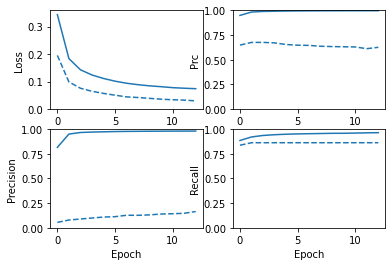

In [60]:
plot_metrics(resampled_history)

In [61]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,

    # These are not real epochs
    steps_per_epoch=20,
    epochs=10 * EPOCHS,

    callbacks=[early_stopping],
    validation_data=(val_ds)
)

Epoch 1/1000
20/20 [==============================] - 4s 78ms/step - loss: 0.6307 - tp: 14794.0000 - fp: 9691.0000 - tn: 56350.0000 - fn: 5694.0000 - accuracy: 0.8222 - precision: 0.6042 - recall: 0.7221 - auc: 0.9035 - prc: 0.6999 - val_loss: 0.6082 - val_tp: 67.0000 - val_fp: 17049.0000 - val_tn: 28441.0000 - val_fn: 12.0000 - val_accuracy: 0.6256 - val_precision: 0.0039 - val_recall: 0.8481 - val_auc: 0.8596 - val_prc: 0.0815
Epoch 2/1000
20/20 [==============================] - 1s 26ms/step - loss: 0.5077 - tp: 17613.0000 - fp: 8525.0000 - tn: 11911.0000 - fn: 2911.0000 - accuracy: 0.7208 - precision: 0.6738 - recall: 0.8582 - auc: 0.8514 - prc: 0.8709 - val_loss: 0.5627 - val_tp: 68.0000 - val_fp: 13752.0000 - val_tn: 31738.0000 - val_fn: 11.0000 - val_accuracy: 0.6980 - val_precision: 0.0049 - val_recall: 0.8608 - val_auc: 0.9032 - val_prc: 0.4260
Epoch 3/1000
20/20 [==============================] - 0s 25ms/step - loss: 0.4455 - tp: 18051.0000 - fp: 7442.0000 - tn: 13068.0000 - 

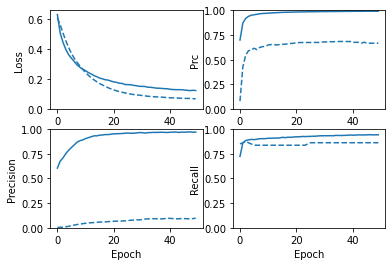

In [62]:
plot_metrics(resampled_history)

In [63]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

28/28 [==============================] - 0s 1ms/step


loss: 0.07641210407018661
tp: 80.0
fp: 814.0
tn: 56064.0
fn: 4.0
accuracy: 0.9856395721435547
precision: 0.08948545902967453
recall: 0.9523809552192688
auc: 0.9934009313583374
prc: 0.7815558314323425
Legitimate transactions detected (True negative): 56064
Legitimate transactions incorrecty detected (False positives): 814
Fraudulent transactions missed (False negatives): 4
Fraudulent transactions detected (True positives): 80
Total fraudulent transactions: 84


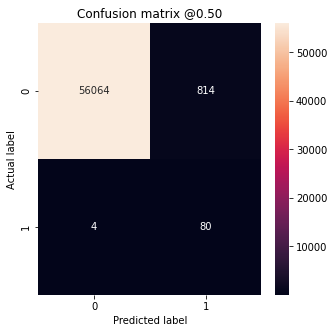

In [64]:
resampled_results = resampled_model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(resampled_model.metrics_names, resampled_results):
    print(f'{name}: {value}')

plot_cm(test_labels, test_predictions_resampled)

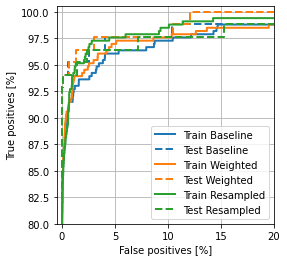

In [65]:
plot_roc('Train Baseline', train_labels, train_predictions_baseline, color=colors[0])
plot_roc('Test Baseline', test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc('Train Weighted', train_labels, train_predictions_weighted, color=colors[1])
plot_roc('Test Weighted', test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc('Train Resampled', train_labels, train_predictions_resampled, color=colors[2])
plot_roc('Test Resampled', test_labels, test_predictions_resampled, color=colors[2], linestyle='--')

plt.legend(loc='lower right');

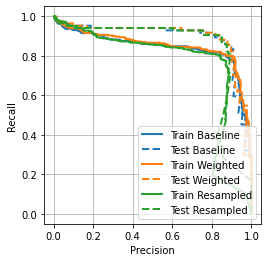

In [66]:
plot_prc('Train Baseline', train_labels, train_predictions_baseline, color=colors[0])
plot_prc('Test Baseline', test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc('Train Weighted', train_labels, train_predictions_weighted, color=colors[1])
plot_prc('Test Weighted', test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_prc('Train Resampled', train_labels, train_predictions_resampled, color=colors[2])
plot_prc('Test Resampled', test_labels, test_predictions_resampled, color=colors[2], linestyle='--')

plt.legend(loc='lower right');